In [3]:
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
from torch.utils.data import DataLoader
import os

print("Pytorch Version: ", torch.__version__)
print("CUDA Available: ", torch.cuda.is_available())

Pytorch Version:  2.2.2
CUDA Available:  False


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cpu')

In [5]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.

[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_dataset_path = "/Users/rss/Documents/Brain_Tumor_Detection/brain_tumor_classifier/MRI-Images-of-Brain-Tumor/timri/train"
val_dataset_path = "/Users/rss/Documents/Brain_Tumor_Detection/brain_tumor_classifier/MRI-Images-of-Brain-Tumor/timri/valid"

In [7]:
print(os.listdir(train_dataset_path))

['pituitary', '.DS_Store', 'no-tumor', 'glioma', 'meningioma']


In [8]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std=[0.229,0.224,0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std=[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(root = train_dataset_path, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dataset_path, transform=transform_val)
print(train_dataset.class_to_idx)


{'glioma': 0, 'meningioma': 1, 'no-tumor': 2, 'pituitary': 3}


In [9]:
image, label = train_dataset[0]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
0


In [10]:
class BrainTumorModel(nn.Module):

  def __init__(self, num_classes=4, freeze_layers = True):
    super(BrainTumorModel, self).__init__()

    self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    in_features = self.backbone.fc.in_features
    self.backbone.fc = nn.Linear(in_features, num_classes)

    if freeze_layers:
      for param in self.backbone.parameters():
        param.requires_grad = False

      for param in self.backbone.layer4.parameters():
        param.requires_grad = True

      for param in self.backbone.fc.parameters():
        param.requires_grad = True

  def forward(self, x):
    return self.backbone(x)

In [11]:
model = BrainTumorModel()
model = model.to(device)

In [12]:
total_trainable_param = 0
for name, param in model.named_parameters():
    if param.requires_grad:
      total_trainable_param += param.numel()


In [13]:
total_trainable_param

8395780

In [14]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr = 0.0003,
    weight_decay = 1e-4
)

In [15]:
epochs = 10

In [16]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    pin_memory = True,
    num_workers = 2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

In [17]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [34]:
best_val_loss = float("inf")
for epoch in range(epochs):
  model.train()
  train_loss = 0

  for features, labels in train_loader:
    features,labels = features.to(device), labels.to(device)
    optimizer.zero_grad()
    y_pred = model(features)
    loss = loss_function(y_pred, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  avg_train_loss = train_loss/len(train_loader)

  model.eval()
  val_loss = 0
  with torch.no_grad():
    for features, labels in val_loader:
      features,labels = features.to(device), labels.to(device)
      output = model(features)
      loss = loss_function(output, labels)
      val_loss += loss.item()

  avg_val_loss = val_loss/len(val_loader)

  if avg_val_loss < best_val_loss:
    best_val_loss = avg_val_loss
    torch.save(model.state_dict(), "best_model.pth")

  print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")


Epoch 1/10 | Train Loss: 0.1723 | Val Loss: 0.0691
Epoch 2/10 | Train Loss: 0.0679 | Val Loss: 0.0522
Epoch 3/10 | Train Loss: 0.0406 | Val Loss: 0.0753
Epoch 4/10 | Train Loss: 0.0379 | Val Loss: 0.0447
Epoch 5/10 | Train Loss: 0.0281 | Val Loss: 0.0442
Epoch 6/10 | Train Loss: 0.0203 | Val Loss: 0.0418
Epoch 7/10 | Train Loss: 0.0148 | Val Loss: 0.0258
Epoch 8/10 | Train Loss: 0.0084 | Val Loss: 0.0248
Epoch 9/10 | Train Loss: 0.0179 | Val Loss: 0.0512
Epoch 10/10 | Train Loss: 0.0124 | Val Loss: 0.0471


In [35]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total


In [36]:
val_acc

98.97483690587138

In [37]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

train_acc = 100 * correct / total


In [38]:
train_acc

99.84038308060654

In [18]:
model = BrainTumorModel()
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model = model.to(device)
model.eval()

BrainTumorModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [19]:
num_classes = 4
conf_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        _, preds = torch.max(outputs, 1)

        for t, p in zip(labels.view(-1), preds.view(-1)):
            conf_matrix[t.long(), p.long()] += 1

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
tensor([[255.,   0.,   0.,   0.],
        [  0., 240.,   1.,   4.],
        [  0.,   0., 282.,   0.],
        [  0.,   1.,   0., 290.]])


In [20]:
precision = conf_matrix.diag() / conf_matrix.sum(0)
recall = conf_matrix.diag() / conf_matrix.sum(1)
f1 = 2 * (precision * recall) / (precision + recall)

print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1 Score per class:", f1)

Precision per class: tensor([1.0000, 0.9959, 0.9965, 0.9864])
Recall per class: tensor([1.0000, 0.9796, 1.0000, 0.9966])
F1 Score per class: tensor([1.0000, 0.9877, 0.9982, 0.9915])


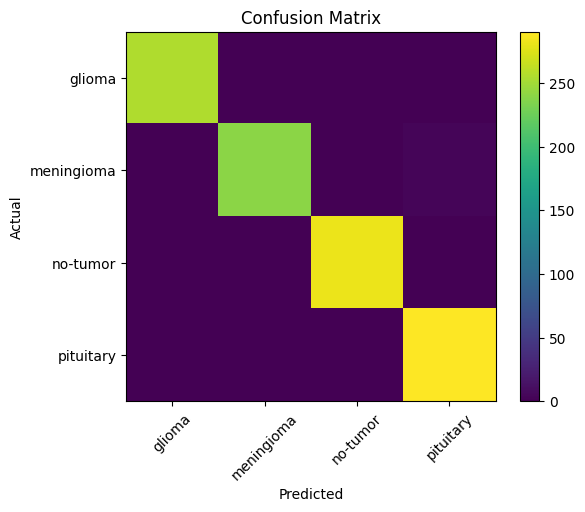

In [21]:
import matplotlib.pyplot as plt
import numpy as np
cm = conf_matrix.cpu().numpy()

plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xticks(range(num_classes), val_dataset.classes, rotation=45)
plt.yticks(range(num_classes), val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
